<a href="https://colab.research.google.com/github/nbalatamu/Hybrid-Dynamic-Models-for-Species-Dynamics/blob/main/Human01A1_HDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import numpy as np
from tqdm.notebook import tqdm
import time
from sklearn.metrics import r2_score
import math
import torch.nn.functional as F
%matplotlib inline

In [2]:
!pip install torchdiffeq
from torchdiffeq import odeint_adjoint

In [3]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Set random seeds for reproducibility
def set_random_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

set_random_seeds()

In [29]:
df_5 = pd.read_csv('/content/Human01A1.ASV.Top1000.csv')
df_env = pd.read_csv('/content/Human01A1.Env.fillna.csv')

In [30]:
df_5.head()

,ID,DonorA_Stool2,DonorA_Stool4,DonorA_Stool5,DonorA_Stool6,DonorA_Stool7,DonorA_Stool8,DonorA_Stool9,DonorA_Stool10,DonorA_Stool12,...,DonorA_Stool58,DonorA_Stool59,DonorA_Stool60,DonorA_Stool61,DonorA_Stool64,DonorA_Stool65,DonorA_Stool66,DonorA_Stool67,DonorA_Stool68,DonorA_Stool70
0,OTU_3632,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,OTU_2212,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,OTU_70,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,OTU_344,0,0,1,0,0,1,0,1,1,...,0,1,0,0,0,0,0,0,0,3
4,OTU_266,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df_5_T = df_5.T
df_5_T = df_5_T.drop(['ID'], axis = 0)
df_5_T['Day'] = df_env['Day'].values
df_5_T.set_index('Day', inplace = True)

In [33]:
new_index = [int(i) for i in range(2,71)]
df_5_T_reindex = df_5_T.reindex(new_index)
df_5_T_reindex = df_5_T_reindex.ffill().infer_objects()

<ipython-input-33-23c1f5db3d34>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_5_T_reindex = df_5_T_reindex.ffill().infer_objects()


In [35]:
df_env['day'] = df_env['Day'].values
df_env.set_index('day', inplace = True)
df_env

,SampleID,Day,NUTRITION_CALCIUM_PRECEDING_DAY,NUTRITION_CALORIE_PRECEDING_DAY,NUTRITION_CARB_PRECEDING_DAY,NUTRITION_CHOLESTEROL_PRECEDING_DAY,NUTRITION_FAT_PRECEDING_DAY,NUTRITION_FIBER_PRECEDING_DAY,NUTRITION_PROTEIN_PRECEDING_DAY,NUTRITION_SATFAT_PRECEDING_DAY,NUTRITION_SODIUM_PRECEDING_DAY,NUTRITION_SUGAR_PRECEDING_DAY
day,,,,,,,,,,,,
2,DonorA_Stool2,2,459.275997,2169.096992,269.976057,306.719995,69.973798,27.484800,121.024280,8.045510,3306.275992,28.626380
4,DonorA_Stool4,4,481.422499,3048.030941,447.732461,163.347500,117.748803,24.260719,65.867660,41.497803,2658.950011,238.847248
5,DonorA_Stool5,5,963.692500,2886.947506,392.707702,169.880005,113.406624,41.568500,83.020699,24.470265,2873.777537,233.691249
6,DonorA_Stool6,6,651.994996,2867.537495,482.345773,198.967499,65.005249,22.576000,78.349526,20.795597,2327.970030,218.533299
7,DonorA_Stool7,7,1355.102659,2889.136671,336.831045,380.018793,122.468517,22.343800,117.192147,30.890252,3225.523337,148.027523
...,...,...,...,...,...,...,...,...,...,...,...,...
65,DonorA_Stool65,65,680.315666,2236.010335,296.965244,246.234999,89.390257,21.384333,74.041227,28.858601,2708.807994,119.659207
66,DonorA_Stool66,66,977.466665,1818.960475,181.998561,169.994287,89.697981,11.408905,70.549752,33.173316,3074.968588,52.805953
67,DonorA_Stool67,67,890.080002,2620.380014,299.599299,260.590000,118.647801,27.828000,91.966801,29.943771,3024.540001,115.203700


In [36]:
new_index = [int(i) for i in range(2,71)]
df_env_reindex = df_env.reindex(new_index)
df_env_reindex = df_env_reindex.fillna(method = 'ffill')
df_env_reindex

<ipython-input-36-463237c9ae20>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_env_reindex = df_env_reindex.fillna(method = 'ffill')


,SampleID,Day,NUTRITION_CALCIUM_PRECEDING_DAY,NUTRITION_CALORIE_PRECEDING_DAY,NUTRITION_CARB_PRECEDING_DAY,NUTRITION_CHOLESTEROL_PRECEDING_DAY,NUTRITION_FAT_PRECEDING_DAY,NUTRITION_FIBER_PRECEDING_DAY,NUTRITION_PROTEIN_PRECEDING_DAY,NUTRITION_SATFAT_PRECEDING_DAY,NUTRITION_SODIUM_PRECEDING_DAY,NUTRITION_SUGAR_PRECEDING_DAY
day,,,,,,,,,,,,
2,DonorA_Stool2,2.0,459.275997,2169.096992,269.976057,306.719995,69.973798,27.484800,121.024280,8.045510,3306.275992,28.626380
3,DonorA_Stool2,2.0,459.275997,2169.096992,269.976057,306.719995,69.973798,27.484800,121.024280,8.045510,3306.275992,28.626380
4,DonorA_Stool4,4.0,481.422499,3048.030941,447.732461,163.347500,117.748803,24.260719,65.867660,41.497803,2658.950011,238.847248
5,DonorA_Stool5,5.0,963.692500,2886.947506,392.707702,169.880005,113.406624,41.568500,83.020699,24.470265,2873.777537,233.691249
6,DonorA_Stool6,6.0,651.994996,2867.537495,482.345773,198.967499,65.005249,22.576000,78.349526,20.795597,2327.970030,218.533299
...,...,...,...,...,...,...,...,...,...,...,...,...
66,DonorA_Stool66,66.0,977.466665,1818.960475,181.998561,169.994287,89.697981,11.408905,70.549752,33.173316,3074.968588,52.805953
67,DonorA_Stool67,67.0,890.080002,2620.380014,299.599299,260.590000,118.647801,27.828000,91.966801,29.943771,3024.540001,115.203700
68,DonorA_Stool68,68.0,115.072500,2320.031747,363.669657,106.000000,29.856200,20.199500,58.454350,8.583700,2505.469606,102.260157


In [37]:
numpy_array = df_5_T_reindex.to_numpy().astype('float32')
np_array = numpy_array.reshape(69, 1000)
#np_array[:,:,:] = np_array[:,:,:]/1000
y = torch.from_numpy(np_array)
y.shape

torch.Size([69, 1000])

In [38]:
def data_preprocessing_for_df_env(df_env):

  #This function preprocesses the data to get them in the right format
  #Output is a PyTorch Tensor of environmental variables with shape (time points, # of env vars)
  #Input is a pandas dataframe of environmetal factors data

  df_env_processed = df_env.set_index('SampleID')
  df_env_processed_norm = (df_env_processed - df_env_processed.mean())/df_env_processed.std()
  numpy_array_env = df_env_processed_norm.to_numpy().astype('float32')
  e = torch.from_numpy(numpy_array_env)

  return e

In [39]:
e = data_preprocessing_for_df_env(df_env_reindex)

In [40]:
y.shape, e.shape

(torch.Size([69, 1000]), torch.Size([69, 11]))

In [41]:
def data_sort_by_abundance(x, train_time_points):

  #This function sorts the data by abundance in descending order.
  #Sorting is based on total abundance on the train_time_points

  species_sum = x[:train_time_points, :].sum(dim=0)
  sorted_indices = torch.argsort(species_sum, descending=True)
  sorted_x = x[:, sorted_indices]
  return sorted_x, sorted_indices

In [42]:
x, sorted_indices = data_sort_by_abundance(y, 69-12)

#Data Transformations

In [45]:
def geo_mean_overflow(iterable):
    return np.exp(np.log(iterable).mean(axis=1))

def relative_abundance(c,add=0):
    """ calculate relative abudance andd add a value for 0 value"""
    c=c/c.sum(axis=1)[:,None]
    c[c==0]=add
    c=c/c.sum(axis=1)[:,None]
    return(c)

def Centerlogtransform(c,add=0.01):
    """ centered log ratio for community data"""
    c=relative_abundance(c,add=add)
    c=np.log(c/geo_mean_overflow(c)[:,None])
    return c

def Centerlogtransform_back(comm):
    """ transform back for centered log ratio"""
    c=np.exp(comm)/np.exp(c).sum(axis=1)[:,None]
    return c

In [46]:
x = relative_abundance(x)

#Utility Functions

In [48]:
def data_split(x, e, test_size, val_size):

  #This function splits the data into train, validation, and test sets

  train_size = x.shape[0] - val_size - test_size

  train_x, train_e = x[:train_size], e[:train_size]
  val_x, val_e = x[train_size:train_size+val_size], e[train_size:train_size+val_size]
  test_x, test_e = x[train_size+val_size:], e[train_size+val_size:]

  return train_x, val_x, test_x, train_e, val_e, test_e

In [49]:
def get_batch(train_time_points, t_train, train_x, train_e, batch_time = 12, batch_size = 8):
  s = torch.from_numpy(np.random.choice(np.arange(train_time_points - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = train_x[s]  # (batch_size, 1, emb)
  batch_t = t_train[:batch_time]  # (T)
  batch_y = torch.stack([train_x[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, emb)
  batch_e = torch.stack([train_e[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, emb)
  return batch_y0, batch_t, batch_y, batch_e

#Hybrid Dynamic Model

In [50]:
# Custom linear layer with Gaussian initialization
# We custom build this layer to make sure that the diagonal elements of the community
# matrix are always negative even during training
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, mu=0.0, sigma=1.0):
        super(CustomLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.diagonal_weight = nn.Parameter(torch.Tensor(min(in_features, out_features)))
        self.mu = mu
        self.sigma = sigma
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.weight, mean=self.mu, std=self.sigma)
        nn.init.normal_(self.diagonal_weight, mean=self.mu, std=self.sigma)  # Initialize normally with given mean and std
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        weight = self.get_weight()
        return F.linear(input, weight, self.bias)

    def get_weight(self):
        weight = self.weight.clone()
        diagonal_indices = torch.arange(min(self.in_features, self.out_features))
        weight[diagonal_indices, diagonal_indices] = -torch.exp(self.diagonal_weight)
        return weight

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}, mu={}, sigma={}'.format(
            self.in_features, self.out_features, self.bias is not None, self.mu, self.sigma
        )

In [78]:
# Define the combined ODE model
class CombinedODEModel(nn.Module):
    def __init__(self, n, m, t_step):
        super(CombinedODEModel, self).__init__()
        self.n = n
        self.m = m
        self.t_step = t_step

        self.net_1 = nn.Linear(n, m)
        #self.net_2 = nn.Linear(m, m, bias=False)
        self.net_2 = CustomLinear(m, m, bias = False, mu=0.0, sigma=0.001)
        self.net_3 = nn.Sequential(
            nn.Linear(m, 100),
            nn.ReLU(),
            nn.Linear(100, m),
            nn.ReLU()
        )

        self.net_1.weight.data.normal_(0, 0.001)
        #self.net_2.weight.data.normal_(0, 0.001)
        self.net_3[0].weight.data.normal_(0, 0.001)
        self.net_3[2].weight.data.normal_(0, 0.001)

        self.e = None  # Placeholder for control variables

    def set_control_variables(self, e):
        self.e = e

    def forward(self, t, x):
        # Get the control variables at the current time step for all batches
        t_index = int(t.item() / self.t_step)
        e_t = self.e[t_index, :, :]
        return x * (self.net_1(e_t) + self.net_2(x) + self.net_3(x))

#Training and Optimization Functions

In [79]:
def train_and_optimize_model(model_class,
                             hyperparameters,
                             get_batch, train_x, train_e,
                             x, e, t_train, t_val, train_time_points, val_time_points, val_x,
                             niters=100, early_stopping_patience=40, early_stopping_min_delta=1e-4, model_args=None):

    best_val_loss = float('inf')
    best_hyperparams = None
    best_model_state = None

    for batch_time, batch_size, lr in hyperparameters:
        print(f"Training with batch_time={batch_time}, batch_size={batch_size}, lr={lr}")

        # Create the model
        if model_args:
          print("Model args:", model_args)
          model = model_class(model_args[0], model_args[1], model_args[2]).to(device)
        else:
          model = model_class().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loss = []
        val_loss = []

        best_epoch_val_loss = float('inf')
        patience_counter = 0

        for iter in tqdm(range(niters + 1)):
            # Train loss
            optimizer.zero_grad()
            batch_y0, batch_t, batch_y, batch_e = get_batch(train_time_points, t_train, train_x, train_e, batch_time, batch_size)
            batch_y0 = batch_y0.to(device)
            batch_t = batch_t.to(device)
            batch_y = batch_y.to(device)
            batch_e = batch_e.to(device)
            model.set_control_variables(batch_e)
            y_pred = odeint_adjoint(model, batch_y0, batch_t, rtol=1e-3, atol=1e-4, method='euler')
            loss = torch.mean(torch.square(y_pred - batch_y))
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

            # Val loss
            with torch.no_grad():
                model.eval()
                x = x.to(device)
                e = e.to(device)
                val_x = val_x.to(device)
                t_val = t_val.to(device)
                model.set_control_variables(e.unsqueeze(1))
                y_pred_val = odeint_adjoint(model, x.unsqueeze(1)[0, :, :], t_val, rtol=1e-3, atol=1e-4, method='euler')
                val_loss_value = torch.mean(torch.square(y_pred_val[train_time_points:,:,:] - val_x.unsqueeze(1)))
                val_loss.append(val_loss_value.item())

            if torch.isnan(val_loss_value):
                print(f"NaN detected for batch_time={batch_time}, batch_size={batch_size}, lr={lr} at epoch {iter}")
                break

            if val_loss_value < best_epoch_val_loss - early_stopping_min_delta:
                best_epoch_val_loss = val_loss_value
                patience_counter = 0
                if val_loss_value < best_val_loss:
                    best_val_loss = val_loss_value
                    best_hyperparams = {'batch_time': batch_time, 'batch_size': batch_size, 'learning_rate': lr}
                    best_model_state = model.state_dict()
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {iter}")
                break

        print(f"Best Val Loss after training: {best_epoch_val_loss}")

        plt.figure(figsize=(4, 2))
        plt.plot(train_loss, label='train')
        plt.plot(val_loss, label='val')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    #print(f"Best hyperparameters: {best_hyperparams}, Best validation loss: {best_val_loss}")

    return best_model_state, best_hyperparams, best_val_loss

-----------------------------------------Training-----------------------------------------
------------------------------------------------------------------------------------------
Training with batch_time=56, batch_size=1, lr=0.001
Model args: (11, 1000, 0.014705882407724857)


  0%|          | 0/1001 [00:00<?, ?it/s]

Early stopping at epoch 359
Best Val Loss after training: 1.0269319318467751e-05


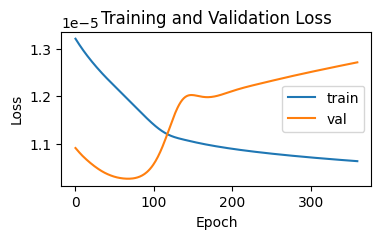

Training with batch_time=56, batch_size=1, lr=0.0001
Model args: (11, 1000, 0.014705882407724857)


  0%|          | 0/1001 [00:00<?, ?it/s]

Early stopping at epoch 469
Best Val Loss after training: 1.0019793080573436e-05


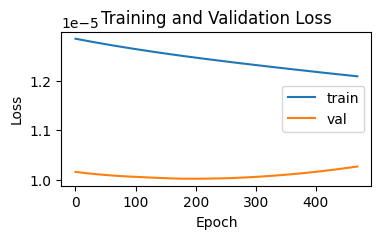

Training with batch_time=47, batch_size=10, lr=0.001
Model args: (11, 1000, 0.014705882407724857)


  0%|          | 0/1001 [00:00<?, ?it/s]

Early stopping at epoch 306
Best Val Loss after training: 8.999044439406134e-06


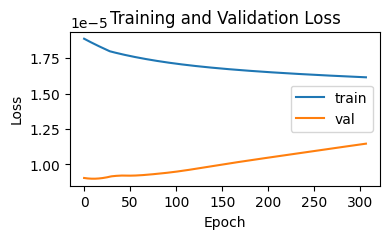

Training with batch_time=47, batch_size=10, lr=0.0001
Model args: (11, 1000, 0.014705882407724857)


  0%|          | 0/1001 [00:00<?, ?it/s]

Best Val Loss after training: 9.535918252367992e-06


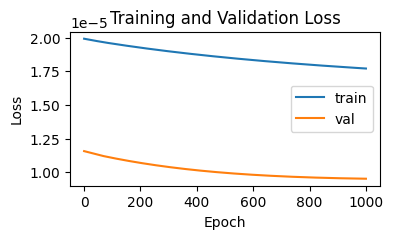

Training with batch_time=37, batch_size=20, lr=0.001
Model args: (11, 1000, 0.014705882407724857)


  0%|          | 0/1001 [00:00<?, ?it/s]

Early stopping at epoch 390
Best Val Loss after training: 1.066440836439142e-05


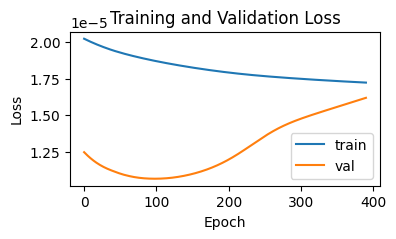

Training with batch_time=37, batch_size=20, lr=0.0001
Model args: (11, 1000, 0.014705882407724857)


  0%|          | 0/1001 [00:00<?, ?it/s]

Best Val Loss after training: 1.1021911632269621e-05


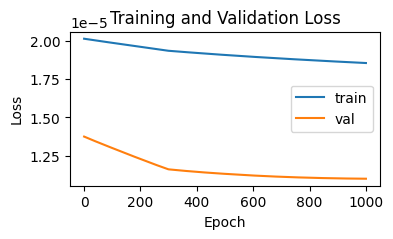

Training with batch_time=27, batch_size=30, lr=0.001
Model args: (11, 1000, 0.014705882407724857)


  0%|          | 0/1001 [00:00<?, ?it/s]

Early stopping at epoch 327
Best Val Loss after training: 9.609359949536156e-06


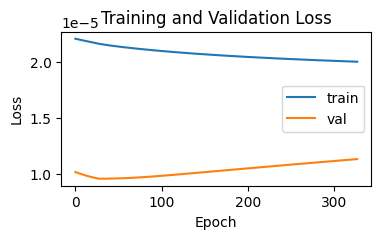

Training with batch_time=27, batch_size=30, lr=0.0001
Model args: (11, 1000, 0.014705882407724857)


  0%|          | 0/1001 [00:00<?, ?it/s]

Early stopping at epoch 643
Best Val Loss after training: 9.908891115628649e-06


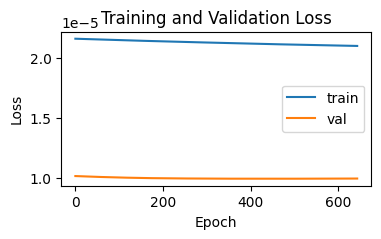

Training with batch_time=17, batch_size=40, lr=0.001
Model args: (11, 1000, 0.014705882407724857)


  0%|          | 0/1001 [00:00<?, ?it/s]

Early stopping at epoch 354
Best Val Loss after training: 1.0325007679057308e-05


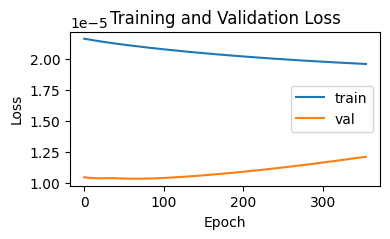

Training with batch_time=17, batch_size=40, lr=0.0001
Model args: (11, 1000, 0.014705882407724857)


  0%|          | 0/1001 [00:00<?, ?it/s]

Best Val Loss after training: 9.64990340435179e-06


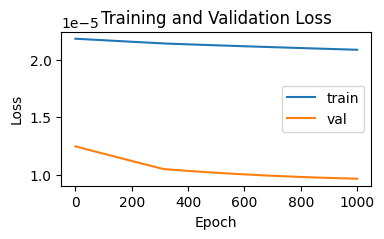

-----------------------------------------Summary-----------------------------------------
------------------------------------------------------------------------------------------
Best Validation Loss: 8.999044439406134e-06
Test loss is: 1.5383257050416432e-05
Best hyperparameters: {'batch_time': 47, 'batch_size': 10, 'learning_rate': 0.001}


In [108]:
test_time_points = 6
val_time_points = 6

n = e.shape[1]                # number of environmental variables
m = 1000                      # top m ASVs; has to be less than or equal to total_asvs


train_time_points = x.shape[0] - val_time_points - test_time_points
train_x, val_x, test_x, train_e, val_e, test_e = data_split(x, e, test_time_points, val_time_points)

t = torch.linspace(0, 1, x.shape[0])
t_train = t[ : train_time_points]
t_val = t[ : train_time_points + val_time_points]
t_test = t[ : train_time_points + val_time_points + test_time_points]

print('-----------------------------------------Training-----------------------------------------')
print('------------------------------------------------------------------------------------------')


# Define hyperparameters
hyperparameters = [
        (train_time_points-1, 1, 0.001), (train_time_points-1, 1, 0.0001),
        (train_time_points-10, 10, 0.001), (train_time_points-10, 10, 0.0001),
        (train_time_points-20, 20, 0.001), (train_time_points-20, 20, 0.0001),
        (train_time_points-30, 30, 0.001), (train_time_points-30, 30, 0.0001),
        (train_time_points-40, 40, 0.001), (train_time_points-40, 40, 0.0001)]
          # (batch_time, batch_size, learning_rate)

best_model_state, best_hyperparams, best_val_loss = train_and_optimize_model(CombinedODEModel,
                             hyperparameters,
                             get_batch, train_x, train_e,
                             x, e, t_train, t_val, train_time_points, val_time_points, val_x,
                             niters=1000, early_stopping_patience=300, early_stopping_min_delta=1e-8, model_args=(n,m, t[1].item()))

# Load the best model state
best_model = CombinedODEModel(n, m, t[1].item())
best_model.load_state_dict(best_model_state)
best_model.eval()

# Predict the test data
with torch.no_grad():
  best_model.set_control_variables(e.unsqueeze(1))
  y_pred_test = odeint_adjoint(best_model, x.unsqueeze(1)[0, :, :], t_test, rtol=1e-3, atol=1e-4, method='euler')
  test_loss = torch.mean(torch.square(y_pred_test[train_time_points + val_time_points:, :, :] - test_x.unsqueeze(1)))

print('-----------------------------------------Summary-----------------------------------------')
print('------------------------------------------------------------------------------------------')
print(f'Best Validation Loss: {best_val_loss}')
print(f"Test loss is: {test_loss.item()}")
print(f"Best hyperparameters: {best_hyperparams}")

------------------------------------------------------------------------------------------
Trajectories for top 5 species using the best model
------------------------------------------------------------------------------------------


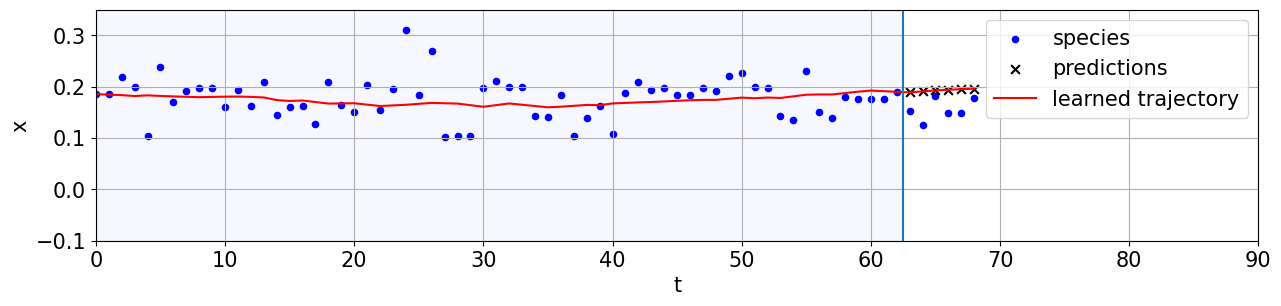

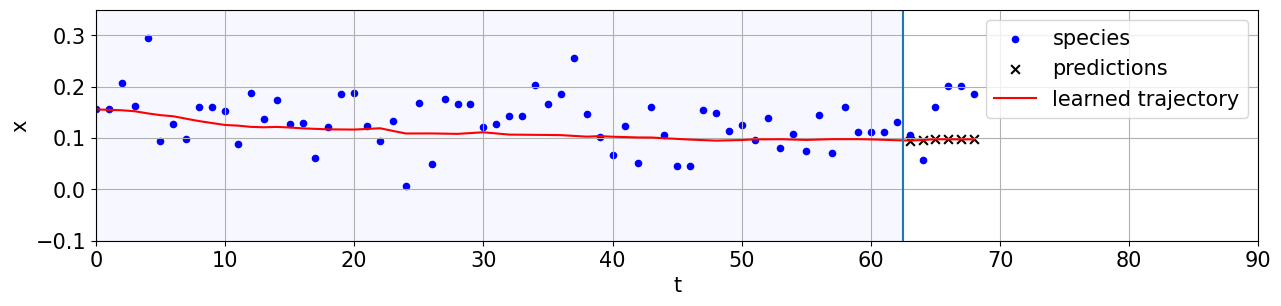

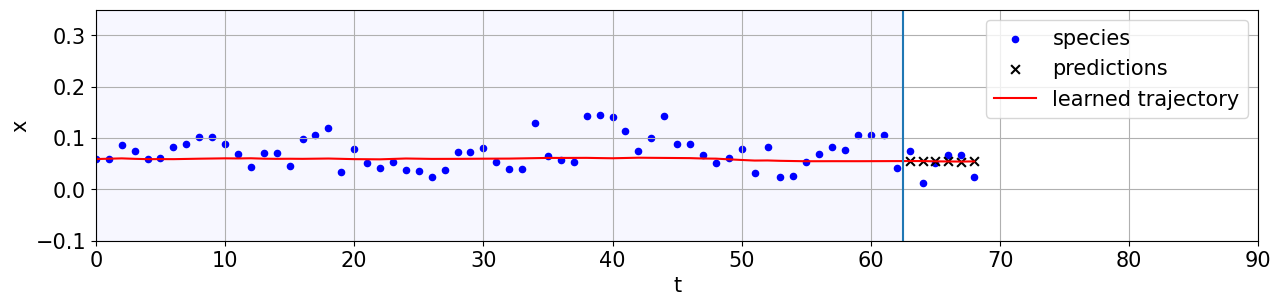

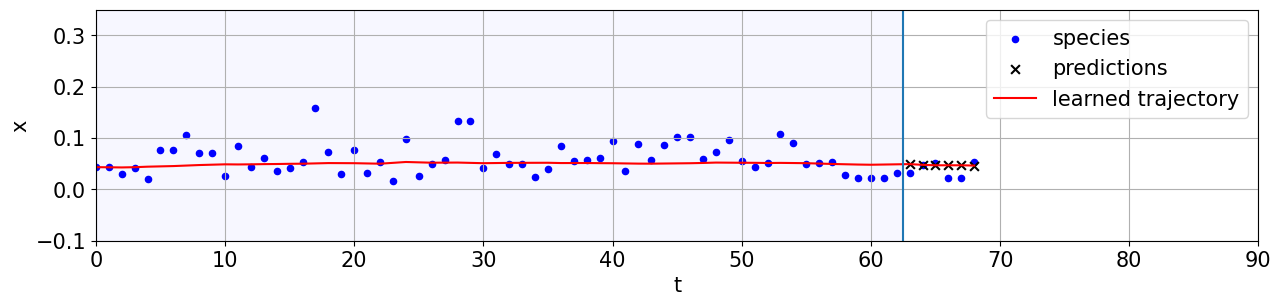

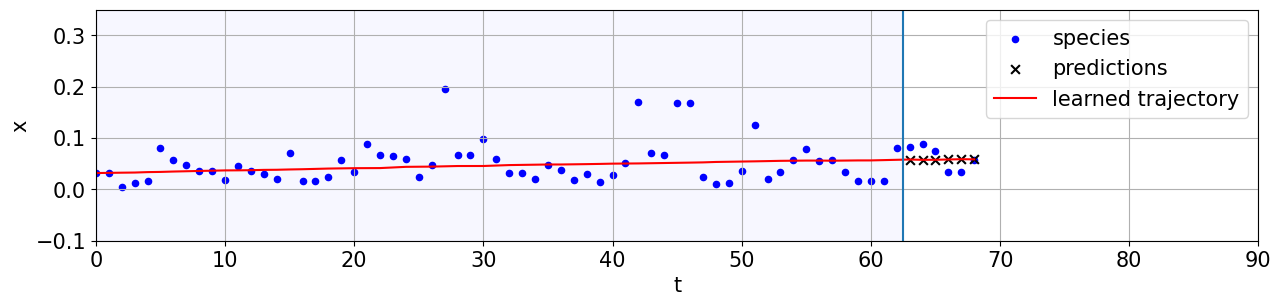

In [109]:
print('------------------------------------------------------------------------------------------')
print('Trajectories for top 5 species using the best model')
print('------------------------------------------------------------------------------------------')

num_species_to_plot = 5

for i in range(num_species_to_plot):
  fig = plt.figure(figsize=(15, 3), facecolor='white')
  ax = fig.add_subplot(111)
  ax.set_xlabel('t', fontsize=15)
  ax.set_ylabel('x', fontsize=15)
  ax.scatter(t_test/t_test[1], x.numpy()[:, i], color='blue', label='species', s=20)
  ax.scatter((t_test/t_test[1])[-test_time_points:], y_pred_test[-test_time_points:,0,i], color = 'black', label = 'predictions', s = 40, marker = 'x')
  ax.plot(t_test/t_test[1], y_pred_test[:,0,i], 'red', label='learned trajectory')
  ax.set_xlim(0, 90)
  ax.set_ylim(-0.1, 0.35)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.axvline(x=train_time_points+val_time_points-0.5)
  ax.axvspan(0, train_time_points+val_time_points-0.5, alpha=0.03, color='blue')
  plt.legend(fontsize = 15)
  plt.grid(True)
  plt.show()

In [110]:
def relative_abundance(comm,add=0):
    """ calculate relative abudance andd add a value for 0 value"""
    comm=comm/comm.sum(axis=1)[:,None]
    comm[comm==0]=add
    comm=comm/comm.sum(axis=1)[:,None]
    return(comm)

from sklearn.metrics import r2_score

def acc(ytrue,ypred):
    """ return accuracy = Ca, precision = r, ccc = rc"""
    if ytrue.ndim<2:
        y=ypred
        x=ytrue
        d = y - x
        m1 = np.mean(y)
        m2 = np.mean(x)
        v1 = np.var(y)
        v2 = np.var(x)
        n = len(d)
        e2 = np.sum(d*d)/n
        mu_d = m1 - m2
        d2 = mu_d**2
        s12 = v1
        s22 = v2 ## var is different for R and python
        U = mu_d/np.sqrt(np.sqrt(s12 * s22))
        V = np.sqrt(s12/s22)
        Ca = 2/(V + 1/V + U**2)
        rc = 1 - e2/(d2 + s12 + s22)
        r = (rc/Ca)
        return Ca, r, rc
    else:
        Ca_sum=0
        r_sum=0
        rc_sum=0
        for i in range(ytrue.shape[1]):
                    y=ypred[:,i]
                    x=ytrue[:,i]
                    d = y - x
                    m1 = np.mean(y)
                    m2 = np.mean(x)
                    v1 = np.var(y)
                    v2 = np.var(x)
                    n = len(d)
                    e2 = np.sum(d*d)/n
                    mu_d = m1 - m2
                    d2 = mu_d**2
                    s12 = v1
                    s22 = v2 ## var is different for R and python
                    U = mu_d/np.sqrt(np.sqrt(s12 * s22))
                    V = np.sqrt(s12/s22)
                    Ca_sum+= 2/(V + 1/V + U**2)
                    rc_sum+= 1 - e2/(d2 + s12 + s22)
                    r_sum == ((1 - e2/(d2 + s12 + s22))/(2/(V + 1/V + U**2)))
        return Ca_sum/ytrue.shape[1], r_sum/ytrue.shape[1], rc_sum/ytrue.shape[1]

In [111]:
y_pred = relative_abundance(y_pred_test[-test_time_points:,0,:].numpy(),add=0.0)
y_test = relative_abundance(test_x.numpy(),add=0.0)

[99.86226527842601, 98.81599292398802, 99.75650685988089, 99.72708065502434, 99.74251871321458, 98.96234641892158]
[94.56363517080071, 87.17733889295538, 95.21736467847529, 86.80937587917295, 86.66545463061043, 88.03046483419827]


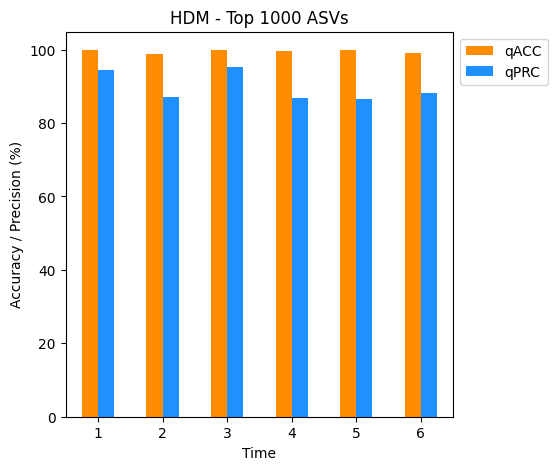

In [112]:
timepoint=[i for i in range(y_test.shape[0])]
results_time={}
for time in timepoint:
  r2 = r2_score(y_test[time,:], y_pred[time,:])
  ccc=acc(y_test[time,:], y_pred[time,:])
  results_time[time]=[r2,ccc[0],ccc[1],ccc[2]] #[r2, accuracy, precision, ccc]

qACC = []
qPRC = []

for week in results_time.keys():
  qACC.append(results_time[week][1]*100)
  qPRC.append(results_time[week][2]*100)

print(qACC)
print(qPRC)

names = ["1","2","3","4",'5','6']
# create the dataframe
df = pd.DataFrame({'qACC': qACC, 'qPRC': qPRC}, index=names)

# plot
colors = {'qACC': 'darkorange', 'qPRC': 'dodgerblue'}
ax = df.plot(kind='bar', figsize=(5, 5), rot=0, title='HDM - Top 1000 ASVs', ylabel='Accuracy / Precision (%)', color=colors)
ax.set_xlabel('Time')
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [113]:
ccc=acc(y_test.flatten(), y_pred.flatten())
print("Accuracy for all test timepoints: ", ccc[0])
print("Precision for all test timepoints: ", ccc[1])

Accuracy for all test timepoints:  0.999367459312423
Precision for all test timepoints:  0.892875341362005


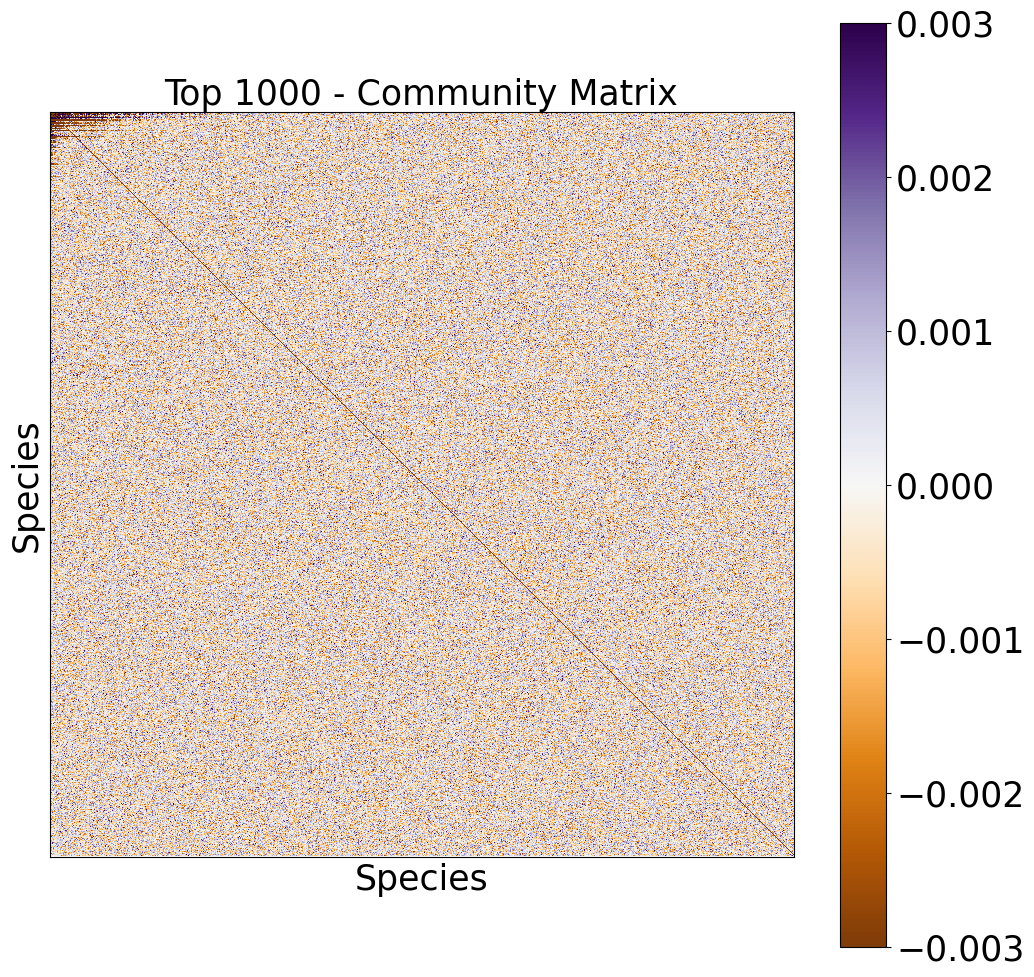

In [114]:
from matplotlib.colors import BoundaryNorm
a = best_model.net_2.get_weight().detach()

# define the colormap
cmap = plt.get_cmap('PuOr')

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize and forcing 0 to be part of the colorbar!
bounds = np.arange(np.min(a.numpy()),np.max(a.numpy()),10)
idx=np.searchsorted(bounds,0)
bounds=np.insert(bounds,idx,0)
norm = BoundaryNorm(bounds, cmap.N)
norm = plt.Normalize(vmin=-.003, vmax=.003)


plt.figure(figsize=(12,12))
plt.imshow(a,interpolation='none',norm=norm,cmap=cmap)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.xlabel('Species', fontsize = 25)
plt.ylabel('Species', fontsize = 25)
plt.title('Top 1000 - Community Matrix', fontsize = 25)
plt.show()

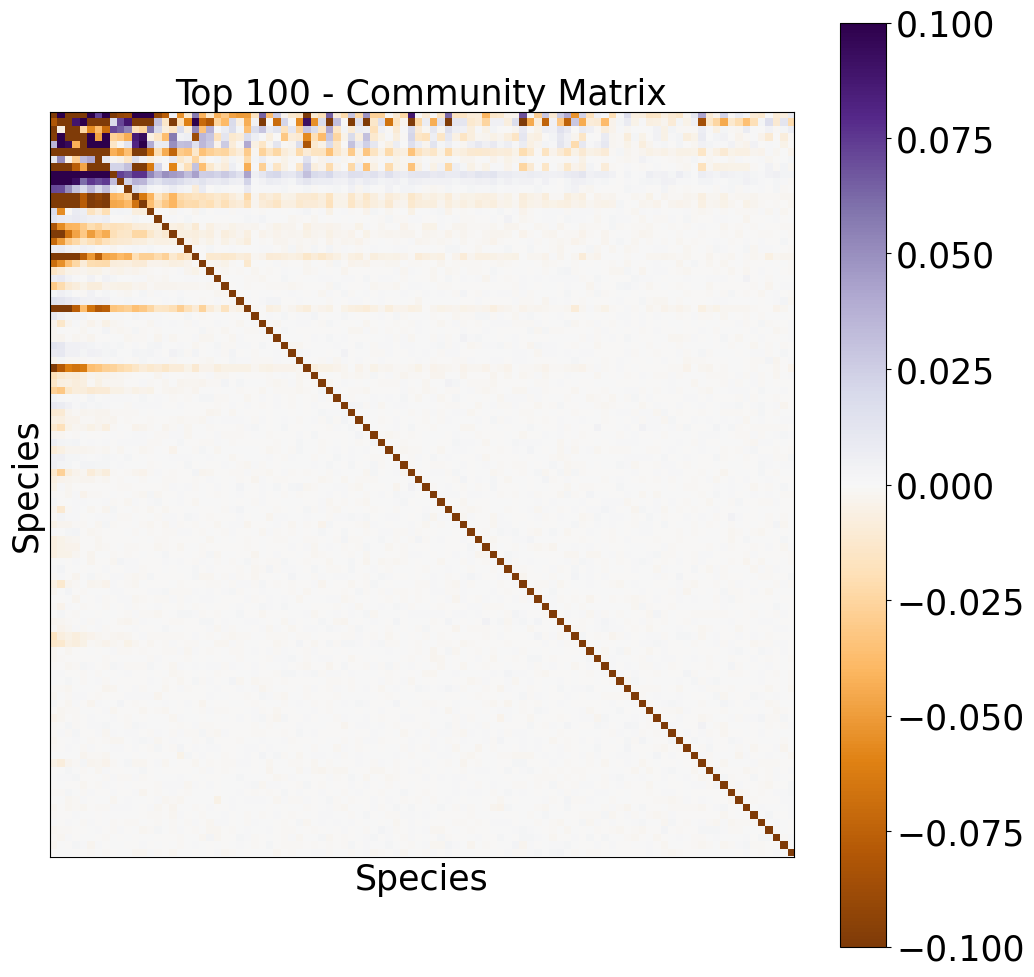

In [115]:
b = a[:100,:100]

# define the colormap
cmap = plt.get_cmap('PuOr')

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize and forcing 0 to be part of the colorbar!
bounds = np.arange(np.min(b.numpy()),np.max(b.numpy()),10)
idx=np.searchsorted(bounds,0)
bounds=np.insert(bounds,idx,0)
norm = BoundaryNorm(bounds, cmap.N)
norm = plt.Normalize(vmin=-.1, vmax=.1)


plt.figure(figsize=(12,12))
plt.imshow(b,interpolation='none',norm=norm,cmap=cmap)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.xlabel('Species', fontsize = 25)
plt.ylabel('Species', fontsize = 25)
plt.title('Top 100 - Community Matrix', fontsize = 25)
plt.show()

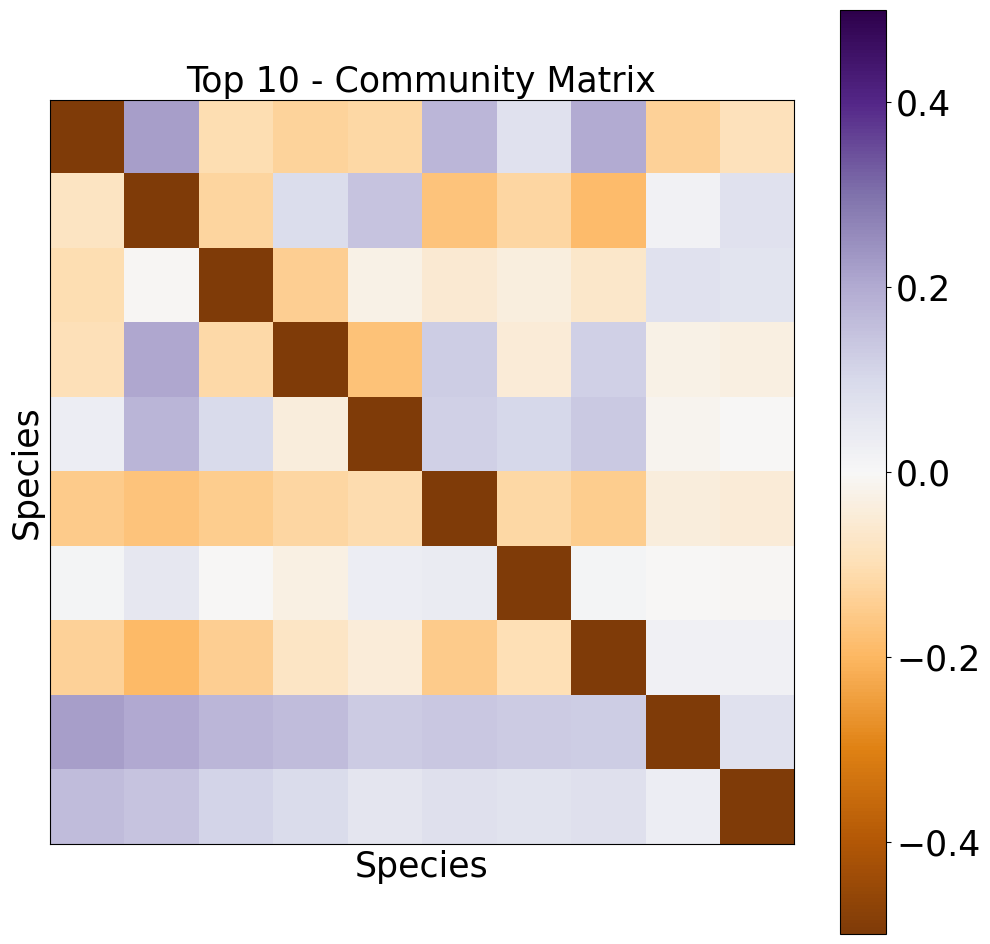

In [116]:
b = a[:10,:10]

# define the colormap
cmap = plt.get_cmap('PuOr')

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize and forcing 0 to be part of the colorbar!
bounds = np.arange(np.min(b.numpy()),np.max(b.numpy()),10)
idx=np.searchsorted(bounds,0)
bounds=np.insert(bounds,idx,0)
norm = BoundaryNorm(bounds, cmap.N)
norm = plt.Normalize(vmin=-.5, vmax=.5)


plt.figure(figsize=(12,12))
plt.imshow(b,interpolation='none',norm=norm,cmap=cmap)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.xlabel('Species', fontsize = 25)
plt.ylabel('Species', fontsize = 25)
plt.title('Top 10 - Community Matrix', fontsize = 25)
plt.show()

In [117]:
r_values = []

with torch.no_grad():
  for i in range(e.shape[0]):
    r = best_model.net_1(e[i])
    r_values.append(r)

# Stack the results into a single tensor
r_tensor = torch.stack(r_values)

# Print or use r_tensor as needed
print(r_tensor.shape)
r_values_np = np.array(r_values)

torch.Size([69, 1000])


------------------------------------------------------------------------------------------
Trajectories for top 5 species birth rates r using the best model
------------------------------------------------------------------------------------------


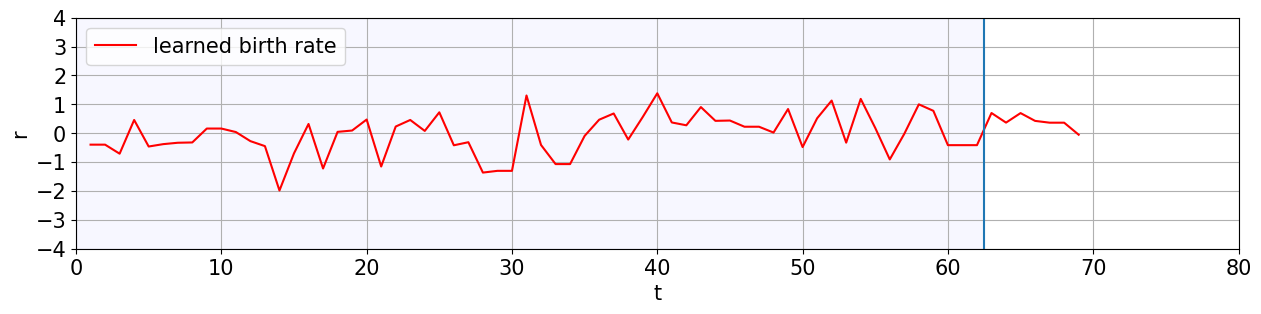

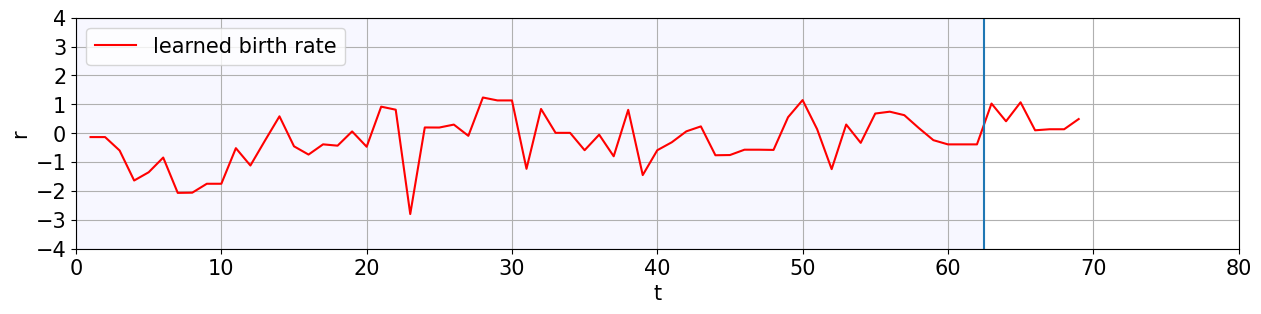

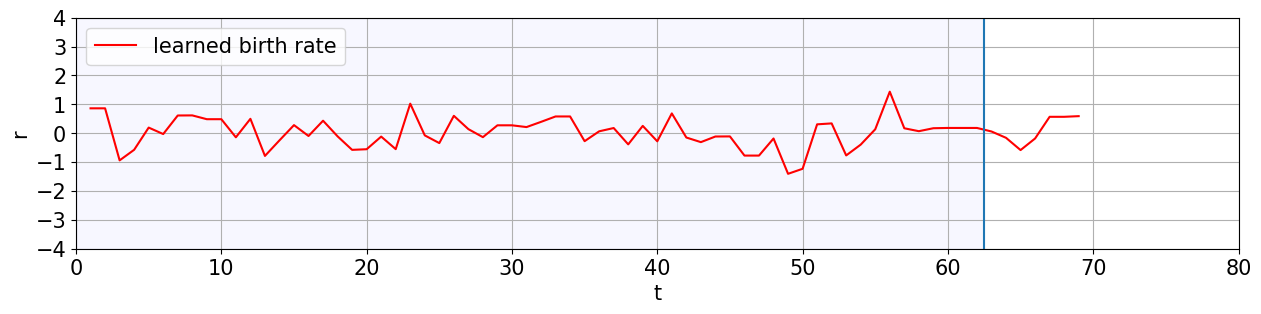

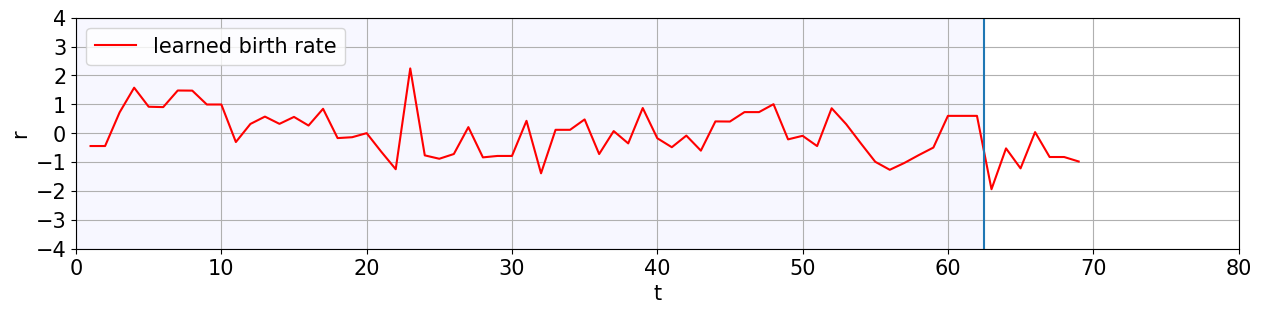

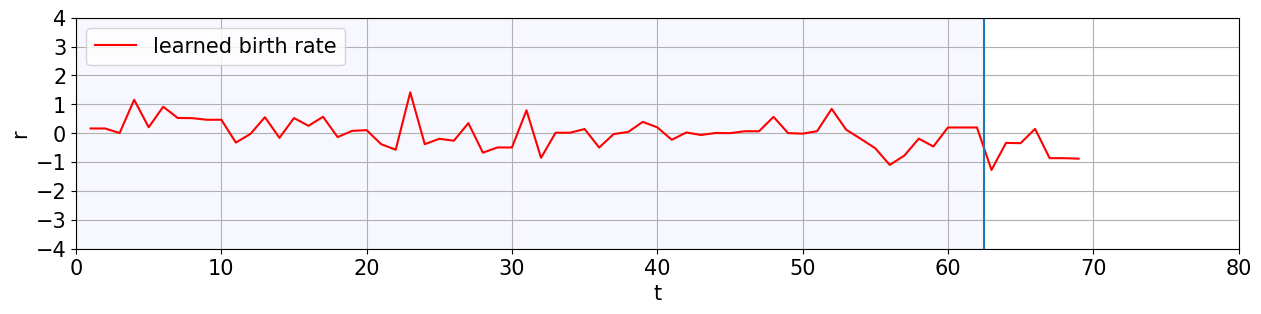

In [118]:
print('------------------------------------------------------------------------------------------')
print('Trajectories for top 5 species birth rates r using the best model')
print('------------------------------------------------------------------------------------------')

num_species_to_plot = 5
t_env = np.linspace(1,69, 69)


for i in range(num_species_to_plot):
  fig = plt.figure(figsize=(15, 3), facecolor='white')
  ax = fig.add_subplot(111)
  ax.set_xlabel('t', fontsize=15)
  ax.set_ylabel('r', fontsize=15)
  ax.plot(t_env, r_values_np[:,i], 'red', label='learned birth rate')
  ax.set_xlim(0, 80)
  ax.set_ylim(-4.0, 4.0)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.axvline(x=train_time_points+val_time_points-0.5)
  ax.axvspan(0, train_time_points+val_time_points-0.5, alpha=0.03, color='blue')
  plt.legend(fontsize = 15)
  plt.grid(True)
  plt.show()